# 1 - Data Reading

In [76]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#read from csv
test_df = pd.read_csv("sat-test-data.csv.dat", header=None)
train_df = pd.read_csv("sat-train.csv.dat", header =None)


# 2 - Global Variables 

In [77]:
test_df
train_df
Y_train = train_df[len(train_df.columns)-1]
X_train = train_df.drop(len(train_df.columns)-1,axis=1)
num_rows_X_train = X_train[0].count()
num_columns_X_train = len(X_train.columns)

# 3 - Utils Functions

In [78]:
######################################
# Function Save Data To CSV
######################################

def saveDataToCSV(Y_pred):
    id_list = range(1, len(Y_pred)+1)
    submission = pd.DataFrame({
        "Id": id_list,
        "Expected": Y_pred
    })
    submission = submission[['Id', 'Expected']]
    submission.to_csv('submission.csv', index=False)
    return


# 4 - Data Pre-Processing

## 2.1 - Missing Values

In [79]:
import scipy.stats as stats
import numpy.ma as ma
import math

######################################
# Strategies based on constants
######################################

#replace by zero - black colour in RGB
def replaceByZero(df):
    return np.nan_to_num(df)

#replace by 255 - white colour in RGB
def replaceBy255(df):
    return df.fillna(255)

#####################################
# Strategies based on columns values
#####################################

#column minimum
def replaceByColumnMinimum(df):
    return df.fillna(df.min())

#column maximum
def replaceByColumnMaximum(df):
    return df.fillna(df.max())

#column mean
def replaceByColumnMean(df):
    return df.fillna(df.mean())

#column median
def replaceByColumnMedian(df):
    return df.fillna(df.median())

#####################################
# Strategies based on rows values
#####################################

# in the analysis of the rows we have to take into account that each four consecutive rows describe a pixel.
# Each of these four rows stands for: Red, Green, IR, IR. |R|G|IR1|IR2|
# These values refer to different things, and therefore are analysed independently.
# this will allow to consider more the specificities of the problem

# divide the data into four datasets, corresponding to each type of values 

#general function to gather columns for each type |R|G|IR1|IR2| using the mod operator
def separatePixelColumns(position, df):
    indexes = range(0, num_columns_X_train-1)
    indexes = [x for x in indexes if x % 4 == position]
    df_p_attribute = df.iloc[:,indexes]
    return df_p_attribute

#general function to fill missing values based on the rows
#Note that does not make sense to consider the four values |R|G|IR1|IR2|, because they refer to different properties
def fillMissingValuesByRow(df, function):
    for index, row in df.iterrows():
        value_without_nan = function(row)
        nan_positions = row.isnull()
        row[nan_positions] = value_without_nan
    return df

#row spectral mean
def replaceByRowMean(df):
    return fillMissingValuesByRow(df, np.nanmean)

#row spectral median
def replaceByRowMedian(df):
    return fillMissingValuesByRow(df, np.nanmedian)

#row spectral minimum
def replaceByRowMinimum(df):
    return fillMissingValuesByRow(df, np.nanmin)

#row spectral maximum
def replaceByRowMinimum(df):
    return fillMissingValuesByRow(df, np.nanmax)

########################################
# Strategies based on data distribution
########################################

#consider the distribution of the spectral values of each type. 
#Get random value from the spectral values of same type

    
def getRandomNumberFromDataframe(df):
    import random
    while True:
        row = df.sample(1)
        values = row.values[0]
        value = random.choice(values)
        if not math.isnan(value):
            break
    return value
        
def fillMissingValuesWithDistribution(df):
    for index, row in df.iterrows():
        nan_positions = row.isnull()
        for i in range(len(nan_positions)): 
            if nan_positions.iloc[i] == True:
                value = getRandomNumberFromDataframe(df)
                row.iloc[i] = value
    return df

In [80]:
#########################################%%%
# fill Missing Values Considering Spectral
#########################################%%%

def fillMissingValuesBySpectral(df, function):

    #generate four new datasets with the columns of each type
    df_p_attribute_R = separatePixelColumns(0, df)
    df_p_attribute_G = separatePixelColumns(1, df)
    df_p_attribute_IR1 = separatePixelColumns(2, df)
    df_p_attribute_IR2 = separatePixelColumns(3, df)

    #apply function to each of the 4 datasets
    df_p_attribute_R = function(df_p_attribute_R)
    df_p_attribute_G = function(df_p_attribute_G)
    df_p_attribute_IR1 = function(df_p_attribute_IR1)
    df_p_attribute_IR2 = function(df_p_attribute_IR2)

    df = pd.concat(
                        [df_p_attribute_R, 
                         df_p_attribute_G,
                         df_p_attribute_IR1,
                         df_p_attribute_IR2], 
                        axis=1
                        )
    return df

X_train = fillMissingValuesBySpectral(X_train, replaceByRowMinimum)
test_df = fillMissingValuesBySpectral(test_df, replaceByRowMinimum)

print(X_train.head())
print("TESTE")
print(test_df.head())

     0     4     8      12    16    20     24    28    32     1   ...    \
0  92.0  84.0  84.0  101.0  92.0  84.0  102.0  88.0  84.0  115.0  ...     
1  84.0  84.0  80.0   92.0  84.0  84.0   88.0  84.0  84.0  102.0  ...     
2  84.0  84.0  84.0   84.0  84.0  84.0   84.0  84.0  84.0  102.0  ...     
3  80.0  84.0  80.0   84.0  84.0  76.0   84.0  84.0  84.0  102.0  ...     
4  84.0  80.0  80.0   84.0  76.0  76.0   84.0  84.0  79.0   94.0  ...     

      30     34    3     7     11     15    19    23     27     31  
0  128.0  113.0  94.0  79.0  83.0  103.0  85.0  81.0  104.0  100.0  
1  113.0  104.0  79.0  83.0  79.0   85.0  81.0  78.0  100.0   87.0  
2  104.0  113.0  83.0  79.0  79.0   81.0  78.0  87.0   87.0   79.0  
3  104.0  104.0  79.0  79.0  76.0   81.0  81.0  81.0   79.0   79.0  
4  104.0  109.0  79.0  76.0  79.0   81.0  81.0  85.0   79.0   79.0  

[5 rows x 35 columns]
TESTE
     0     4     8     12    16    20    24    28    32     1   ...      30  \
0  80.0  76.0  76.0  76.0  

## 2.2 Normalization

There is no need of normalization

# 3 - Choose Model

Nota: adicionar neural networks - new in v 0.18

First goal: discover which type of analyses works better
Second Goal: tune the model

C:\Users\Paula\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


LR: 0.587098 (0.413852)
LDA: 0.630770 (0.414586)
KNN: 0.632496 (0.417100)


C:\Users\Paula\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Paula\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


CART: 0.610096 (0.417251)
NB: 0.603723 (0.412995)


C:\Users\Paula\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Paula\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Paula\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Paula\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Paula\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: Undefined

SVM: 0.000000 (0.000000)


C:\Users\Paula\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Paula\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


NN: 0.583253 (0.402427)
RF: 0.616078 (0.415078)


C:\Users\Paula\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


AB: 0.615245 (0.420583)


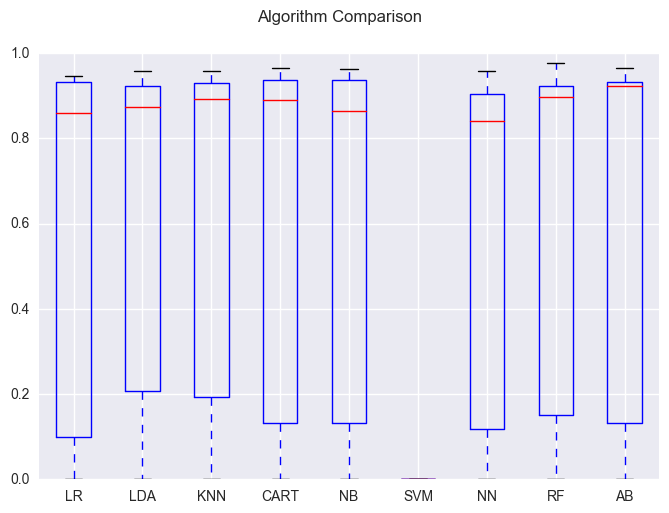

In [74]:
#inspired in http://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

import pandas
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# prepare data

#Y_train = train_df[:,-1]
#X_train = train_df[:,:-1]

#Y_train = train_df[len(train_df.columns)-1]
#X_train = train_df.drop(len(train_df.columns)-1,axis=1)

# prepare configuration for cross validation test harness
num_folds = 10
num_instances = len(X_train)
seed = 7

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('NN', MLPClassifier(alpha=1))) 
models.append(('RF', RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)))
models.append(('AB', AdaBoostClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'f1' # try with 'roc_auc', f1'

for name, model in models:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Submission to Kaggle

In [81]:
# choose algorithm

funtion = AdaBoostClassifier

result = funtion()

result.fit(X_train, Y_train)

Y_pred = result.predict(test_df)

result.score(X_train, Y_train)

Y_pred = Y_pred.astype(int)

# save data to CSV

saveDataToCSV(Y_pred)


# Pipeline

- Poderíamos tentar fazer alguma coisa a ver com anomaly, porque até agora é uma análise muito geral:
-- Pedir frequências das duas classes.
-- Pedir um gráfico com as distribuições dos valores para cada espectro.
-- Ver resultado quando se lida com os Missing values pela estratégia da distribuição
-- ter o cuidado de ver se os resultados não estão a ser influenciados porque o nosso algoritmo diz sempre a mesma classe: ver precision e recall

In [34]:
#ReadData
#XTrain, YTrain, rawTestData = importDataFromFiles()

#handle missing values

#for each different strategy for the missing values check which is the best model in the, get values for accuracy, auc, F1
#check both on the K fold, and on the test dataset

#pick the best strategy for missing values and  the best model and submit to kaggle 


# Próximos Passos:

- criar forma de comparar diferentes estratégias de missing vs diferentes algoritmos, gráfico?
- ver frequências das duas classes
- tentar com algoritmo de anomalia
- escolher melhor algoritmo entre todos (até agora adaboost)
- fazer tuning ao algoritmo
- FIM!

- fazer apresentação e report:

até agora a evolução dos trabalhos a colocar no report será:
- pipeline testing and submission with 0 + adaboost
- improvement in the strategies for missing values - from the different ones the row minimum proved to improve results
- analysis of algorithms + anomaly detection algorithms
- tuning
    